In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../' * 2)
sns.set_style("whitegrid")

In [74]:
import pickle as pkl
from multiprocessing.pool import ThreadPool 
from collections import Counter, defaultdict

from nltk.tokenize import RegexpTokenizer

import config
from src.morphodita import to_tags

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB

# Data preprocessing

In [4]:
if config.PREPROCESSED_DATA_PATH.is_file():
    df = pd.read_csv(config.PREPROCESSED_DATA_PATH)
else:
    df_dict = defaultdict(list)
    for name, directory in [('train', config.RAW_TRAIN_DATA_DIR), ('test', config.RAW_TEST_DATA_DIR)]:
        for file in directory.iterdir():
            if file.suffix == '.txt' and '_' in file.stem:
                df_dict['text'].append(file.read_text())
                df_dict['split'].append(name)
                df_dict['path'].append(file.resolve())
                df_dict['label'].append(file.stem.split('_')[0])
            else:
                print("skipping:", file.resolve())
    
    df = pd.DataFrame.from_dict(df_dict)
    config.PREPROCESSED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(config.PREPROCESSED_DATA_PATH, index=False)
    

labeles = df.label.unique().tolist()
df['y'] = df.label.apply(lambda x: labeles.index(x))

skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_train_34_categories_data/metadata_local.xml
skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_train_34_categories_data/dublin_core.xml
skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_train_34_categories_data/license.txt
skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_train_34_categories_data/contents
skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_train_34_categories_data/handle
skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_test_34_categories_data/metadata_local.xml
skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_test_34_categories_data/dublin_core.xml
skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_test_34_categories_data/license.txt
skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_test_34_categories_data/contents
skipping: /home/mateusz-baran/study/nla/pos-tagging/data/raw/wiki_

In [140]:
df

text  split  \
0     Ernő Gerő (właściwie Ernő Singer (ur. 8 lipca ...  train   
1     Sora - fikcyjna postać i jeden z głównych boha...  train   
2     Pharmakon – albańsko-węgierski film fabularny ...  train   
3     Bujar Lako - (ur. 23 maja 1946 we wsi Lozhan k...  train   
4     Kobalt (Co, łac. cobaltum) – pierwiastek chemi...  train   
...                                                 ...    ...   
9832  Louis-Henri-Joseph Luçon (ur. 28 października ...   test   
9833  '''90 Dywizja Grenadierów Pancernych, niem. Pa...   test   
9834  Pierwszy rejs (tytuł oryginalny: Lundrimi i pa...   test   
9835  \nUkład multifeed to instalacja antenowa telew...   test   
9836  Józef Schindler (ur. 23 listopada 1860, zm. po...   test   

                                                   path  \
0     /home/mateusz-baran/study/nla/pos-tagging/data...   
1     /home/mateusz-baran/study/nla/pos-tagging/data...   
2     /home/mateusz-baran/study/nla/pos-tagging/data...   
3     /home/mateusz-baran/study/nla/pos-tagging/data...   
4     /home/mateusz-baran/study/nla/pos-tagging/data...   
...                                                 ...   
9832  /home/mateusz-baran/study/nla/pos-tagging/data...   
9833  /home/mateusz-baran/study/nla/pos-tagging/data...   
9834  /home/mateusz-baran/study/nla/pos-tagging/data...   
9835  /home/mateusz-baran/study/nla/pos-tagging/data...   
9836  /home/mateusz-baran/study/nla/pos-tagging/data...   

                      label   y  
0                     Zydzi   0  
1           Gry-komputerowe   1  
2                   Albania   2  
3                   Albania   2  
4     Pierwiastki-chemiczne   3  
...                     ...  ..  
9832             Katolicyzm  14  
9833        Wojska-pancerne   4  
9834  Propaganda-polityczna  28  
9835           Astronautyka  19  
9836     Niemieccy-wojskowi  12  

[9837 rows x 5 columns]

In [143]:
df.label.unique()

array(['Zydzi', 'Gry-komputerowe', 'Albania', 'Pierwiastki-chemiczne',
       'Wojska-pancerne', 'Szachy', 'Komiksy', 'Choroby', 'Kultura-Chin',
       'Samoloty', 'Filmy-animowane', 'Karkonosze', 'Niemieccy-wojskowi',
       'Zegluga', 'Katolicyzm', 'Kotowate', 'Monety', 'Sporty-silowe',
       'Egipt', 'Astronautyka', 'Narciarstwo',
       'System-opieki-zdrowotnej-w-Polsce', 'Narkomania', 'Pilka-nozna',
       'Amerykanscy-prozaicy', 'Arabowie', 'Optyka', 'Ekologia-roslin',
       'Propaganda-polityczna', 'Muzyka-powazna', 'Samochody',
       'Rachunkowosc', 'Komputery', 'Galezie-prawa'], dtype=object)

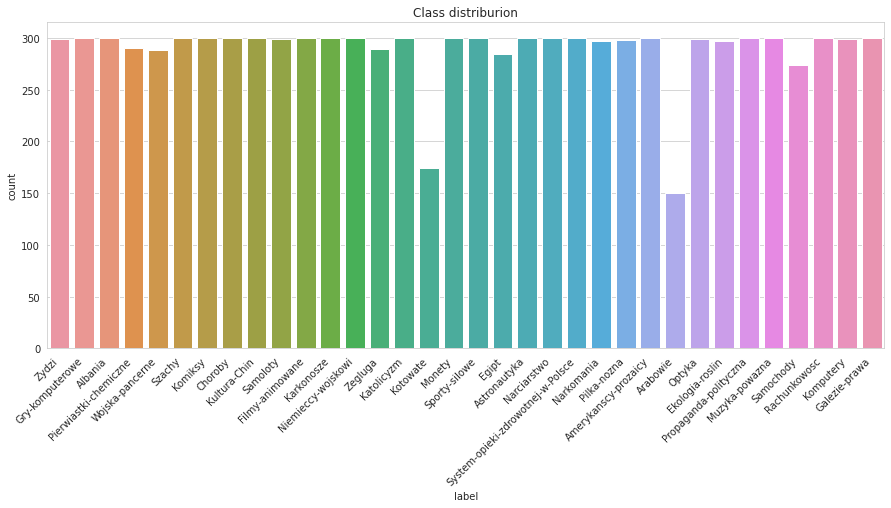

In [135]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=45, horizontalalignment='right')
ax = sns.countplot('label', data=df)
ax.set_title('Class distriburion');

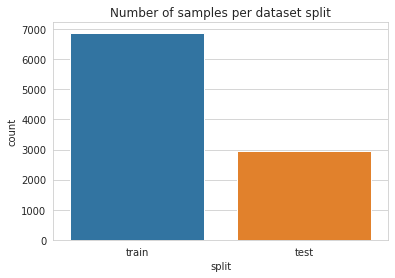

In [139]:
plt.figure(figsize=(6,4))
ax = sns.countplot('split', data=df)
ax.set_title('Number of samples per dataset split');

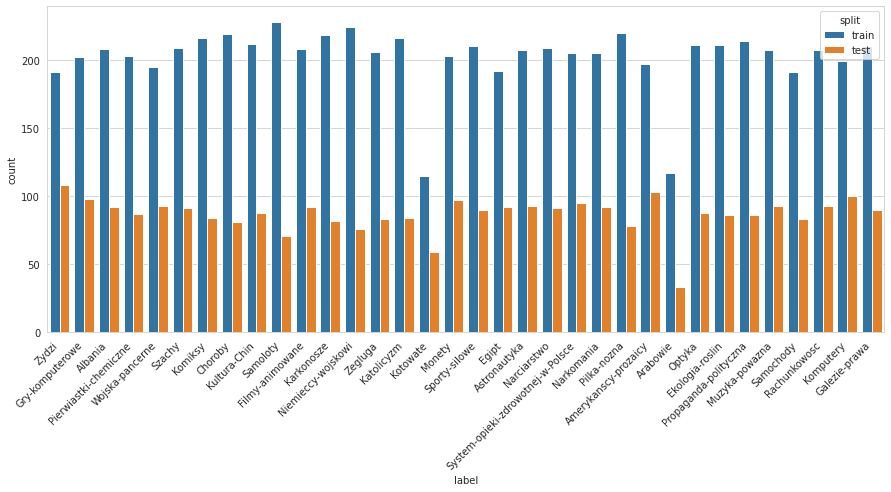

In [12]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=45, horizontalalignment='right')
sns.countplot('label', hue='split', data=df);

In [14]:
df_train = df[df.split == 'train']
df_test = df[df.split == 'test']

# Experiments

In [47]:
punctuation_tokenizer = RegexpTokenizer(r'\w+')

def tokenizer(text: str) -> str:
    text = text.lower()
    
    word_tokens = punctuation_tokenizer.tokenize(text)
    word_tokens = ['_NUM_' if w.isnumeric() else w for w in word_tokens]

    return word_tokens

In [48]:
STOP_WORDS = config.POLISH_STOP_WORDS_PATH.read_text().encode('ASCII','ignore').decode('ASCII').splitlines()


vectorizer = TfidfVectorizer(
    strip_accents='ascii',
    tokenizer=tokenizer,
    stop_words=STOP_WORDS,
    max_df=0.8,
    min_df=0.002,
)

X_train = vectorizer.fit_transform(df_train.text)
y_train = df_train.y

X_test = vectorizer.transform(df_test.text)
y_test = df_test.y

len(vectorizer.get_feature_names())

13433

In [42]:
clf = GaussianNB()
clf.fit(X_train.toarray(), y_train)

GaussianNB()

In [18]:
y_pred = clf.predict(X_test.toarray())

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1-score: ', f1_score(y_test, y_pred, average='macro'))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))

Accuracy:  0.7655826558265583
F1-score:  0.7608921326257166
Precision:  0.7858732609866282
Recall:  0.761103953669507


## pos-tagger

In [70]:
def pos_tagger(text):
    text = text.lower()
    
    word_tokens = punctuation_tokenizer.tokenize(text)
    word_tokens = [w for w in word_tokens if not w.isnumeric()]
    
    word_tokens = to_tags(' '.join(word_tokens))

    return word_tokens

In [76]:
if config.PROCESSED_DATA_PATH.is_file():
    with config.PROCESSED_DATA_PATH.open('rb') as file:
        tagged_train, tagged_test = pkl.load(file)
else:
    with ThreadPool() as pool:
        !date
        tagged_train = pool.map(pos_tagger, df_train.text)
        !date
        tagged_test = pool.map(pos_tagger, df_test.text)
        !date
    
    config.PROCESSED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
    with config.PROCESSED_DATA_PATH.open('wb') as file:
         pkl.dump((tagged_train, tagged_test), file)

In [106]:
def tag_filtering(text_lst, filter_by_pos=None):
    return [' '.join(d['base'] for d in text if not filter_by_pos or d['tag'].split(':')[0] in filter_by_pos) for text in text_lst]

In [129]:
POS = {
    'all': None,
    'noun': {'subst', 'depr'},
    'adjective': {'adj', 'adja', 'adjp', 'adjc'},
    'verb': {'fin', 'bedzie', 'aglt', 'praet', 'impt', 'imps', 'inf', 'pcon', 'pant', 'ger', 'pact', 'ppas', 'winien'},
}

df_results_dict = defaultdict(list)

for max_features in [None, 10_000]:
    for part, tagset in POS.items():
        train_corpus = tag_filtering(tagged_train, filter_by_pos=tagset)
        test_corpus = tag_filtering(tagged_test, filter_by_pos=tagset)

        vectorizer = TfidfVectorizer(
            stop_words=STOP_WORDS,
            max_features=max_features,
        )

        X_train = vectorizer.fit_transform(train_corpus)
        y_train = df_train.y

        X_test = vectorizer.transform(test_corpus)
        y_test = df_test.y

        df_results_dict['pos_name'].append(part)
        df_results_dict['pos_set'].append(tagset)
        df_results_dict['n_features'].append(len(vectorizer.get_feature_names()))
        df_results_dict['max_features'].append(max_features or 'nolimit')

        clf = GaussianNB()
        clf.fit(X_train.toarray(), y_train)

        y_pred = clf.predict(X_test.toarray())

        print('-' * 50)
        print('POS: ', part)
        print('Accuracy: ', accuracy_score(y_test, y_pred))
        print('F1-score: ', f1_score(y_test, y_pred, average='macro'))
        print('Precision: ', precision_score(y_test, y_pred, average='macro'))
        print('Recall: ', recall_score(y_test, y_pred, average='macro'))
        print('Max_features: ', max_features or 'nolimit')
        print('N_features: ', len(vectorizer.get_feature_names()))

        df_results_dict['f1-score'].append(f1_score(y_test, y_pred, average='macro'))
        

df_results = pd.DataFrame.from_dict(df_results_dict)

--------------------------------------------------
POS:  all
Accuracy:  0.799119241192412
F1-score:  0.8000002502028734
Precision:  0.81457642736739
Recall:  0.8001536535924394
Max_features:  nolimit
N_features:  124449
--------------------------------------------------
POS:  noun
Accuracy:  0.7764227642276422
F1-score:  0.7790989658656163
Precision:  0.7947553061376139
Recall:  0.7799650772049657
Max_features:  nolimit
N_features:  87451
--------------------------------------------------
POS:  adjective
Accuracy:  0.6537940379403794
F1-score:  0.6502134977134295
Precision:  0.6565730888201109
Recall:  0.6531117147369465
Max_features:  nolimit
N_features:  20289
--------------------------------------------------
POS:  verb
Accuracy:  0.4495257452574526
F1-score:  0.450061091441125
Precision:  0.4699144444554358
Recall:  0.4485411605418159
Max_features:  nolimit
N_features:  12337
--------------------------------------------------
POS:  all
Accuracy:  0.7574525745257452
F1-score:  0.759

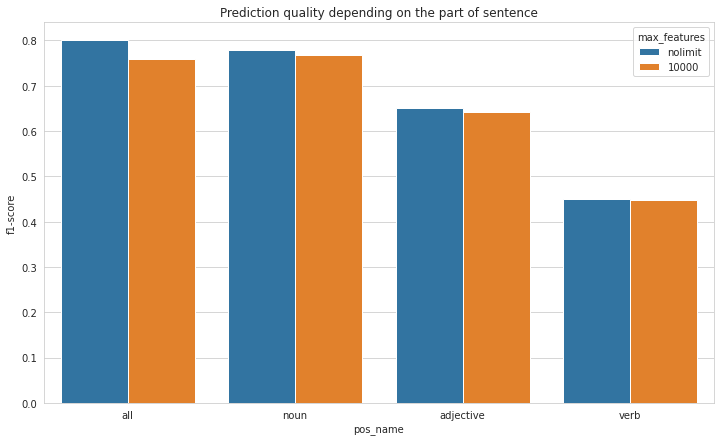

In [134]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='pos_name', y='f1-score', hue='max_features', data=df_results)
ax.set_title('Prediction quality depending on the part of sentence');